In [39]:
# ═══════════════════════════════════════════════════════════════════
# Cell 1: Imports and Configuration
# ═══════════════════════════════════════════════════════════════════

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorcet as cc
import json
import os
from scipy import stats
from tqdm import tqdm
from pathlib import Path

# ── Paths (all relative to this notebook) ────────────────────────
DATA_ROOT = "data"  # contains session folders + laser_calibration.json

# ── Visual defaults ──────────────────────────────────────────────
base_font_size = 14
plt.rcParams.update({
    'font.size': base_font_size,
    'axes.titlesize': base_font_size + 2,
    'axes.labelsize': base_font_size + 1,
    'xtick.labelsize': base_font_size,
    'ytick.labelsize': base_font_size,
    'legend.fontsize': base_font_size,
    'figure.titlesize': base_font_size + 4,
    'svg.fonttype': 'none',
})

# ── Color definitions from colorcet gwv ──────────────────────────
GREEN_COLOR  = cc.gwv[int(0.2 * len(cc.gwv))]   # activated
VIOLET_COLOR = cc.gwv[int(0.8 * len(cc.gwv))]    # inactivated

SAVE_MODE = False
SAVE_DIR  = "plots"
if SAVE_MODE:
    os.makedirs(SAVE_DIR, exist_ok=True)

print(f"Data root: {os.path.abspath(DATA_ROOT)}")
print(f"Sessions available: {sorted(os.listdir(DATA_ROOT))}")

Data root: C:\Users\xander\code\npx_opto\final_code_and_data\data
Sessions available: ['AL0033_2025-07-21_en3_p1', 'AL0033_2025-07-22_en1_p0', 'AL0033_2025-07-22_en3_p0', 'AL0034_2024-12-05_en1_p0', 'AL0034_2024-12-06_en1_p1', 'AL0039_2025-07-23_en1_p0', 'AL0039_2025-07-23_en3_p2', 'AL0039_2025-07-24_en3_p1', 'AL0039_2025-07-24_en5_p2', 'calibration.json', 'calibration.mat', 'laser_calibration.json', 'laser_calibration.mat']


## Cell 2: Load all sessions

In [41]:
def load_session(session_dir):
    """Load a single session from standardized files. Returns a dict."""
    with open(os.path.join(session_dir, "session.json")) as f:
        meta = json.load(f)
    
    session = {
        "meta": meta,
        # Spikes
        "spike_times":    np.load(os.path.join(session_dir, "spikes.times.npy")),
        "spike_clusters": np.load(os.path.join(session_dir, "spikes.clusters.npy")),
        # Clusters
        "templates":          np.load(os.path.join(session_dir, "clusters.templates.npy")),
        "channel_positions":  np.load(os.path.join(session_dir, "clusters.channelPositions.npy")),
        "template_depths":    np.load(os.path.join(session_dir, "clusters.templateDepths.npy")),
        "depths_from_surface":np.load(os.path.join(session_dir, "clusters.depthsFromSurface.npy")),
        "qc_pass":            np.load(os.path.join(session_dir, "clusters.qcPass.npy")),
        "presence_ratio":     np.load(os.path.join(session_dir, "clusters.presenceRatio.npy")),
        "isi_violations":     np.load(os.path.join(session_dir, "clusters.isiViolationsRatio.npy")),
        "amplitude_cutoff":   np.load(os.path.join(session_dir, "clusters.amplitudeCutoff.npy")),
        "trough_to_peak":     np.load(os.path.join(session_dir, "clusters.troughToPeak.npy")),
        "peak_channel":       np.load(os.path.join(session_dir, "clusters.peakChannel.npy")),
        "stim_times":      np.load(os.path.join(session_dir, "stim.times.npy")),
        "emission_sites":  np.load(os.path.join(session_dir, "stim.emissionSites.npy")),
        "power_mW":        np.load(os.path.join(session_dir, "stim.powerMW.npy")),
        "stim_durations":  np.load(os.path.join(session_dir, "stim.durations.npy")),
    }
    
    # Load waveform type from text file
    wvf_path = os.path.join(session_dir, "clusters.waveformType.txt")
    if os.path.exists(wvf_path):
        with open(wvf_path) as f:
            session["waveform_type"] = np.array([line.strip() for line in f])
    else:
        session["waveform_type"] = np.full(session["templates"].shape[0], "", dtype=object)
    
    # Load KSLabel info
    kslabel_path = os.path.join(session_dir, "clusters.KSLabel.csv")
    if os.path.exists(kslabel_path):
        session["cluster_info"] = pd.read_csv(kslabel_path)
    
    return session


# ── Load all sessions ────────────────────────────────────────────
session_dirs = sorted([
    os.path.join(DATA_ROOT, d) for d in os.listdir(DATA_ROOT)
    if os.path.isdir(os.path.join(DATA_ROOT, d))
])

all_sessions = []
for sd in session_dirs:
    s = load_session(sd)
    all_sessions.append(s)
    m = s["meta"]
    print(f"  Loaded {m['session_id']:40s}  "
          f"spikes={m['n_spikes']:>8,}  clusters={m['n_clusters']:>4}  "
          f"trials={m['n_trials']:>} 5 QC={m['n_qc_pass']}/{m['n_clusters']}")

print(f"\nLoaded {len(all_sessions)} sessions total")

  Loaded AL0033_2025-07-21_en3_p1                  spikes= 461,698  clusters= 129  trials=210 5 QC=63/129
  Loaded AL0033_2025-07-22_en1_p0                  spikes= 836,912  clusters= 209  trials=210 5 QC=80/209
  Loaded AL0033_2025-07-22_en3_p0                  spikes=1,470,010  clusters= 264  trials=210 5 QC=126/264
  Loaded AL0034_2024-12-05_en1_p0                  spikes=5,994,793  clusters= 354  trials=630 5 QC=144/354
  Loaded AL0034_2024-12-06_en1_p1                  spikes=2,456,347  clusters= 306  trials=700 5 QC=151/306
  Loaded AL0039_2025-07-23_en1_p0                  spikes=3,182,382  clusters= 339  trials=392 5 QC=105/339
  Loaded AL0039_2025-07-23_en3_p2                  spikes=3,858,666  clusters= 349  trials=392 5 QC=186/349
  Loaded AL0039_2025-07-24_en3_p1                  spikes=3,425,892  clusters= 443  trials=420 5 QC=246/443
  Loaded AL0039_2025-07-24_en5_p2                  spikes=3,754,583  clusters= 430  trials=392 5 QC=253/430

Loaded 9 sessions total


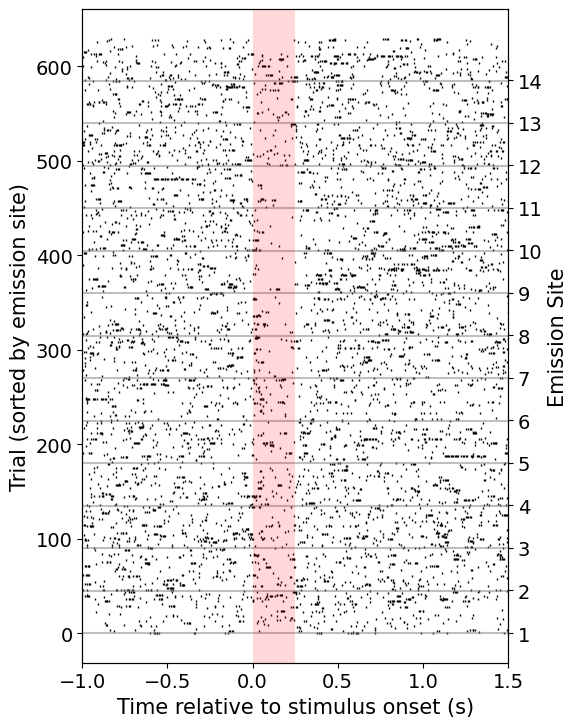

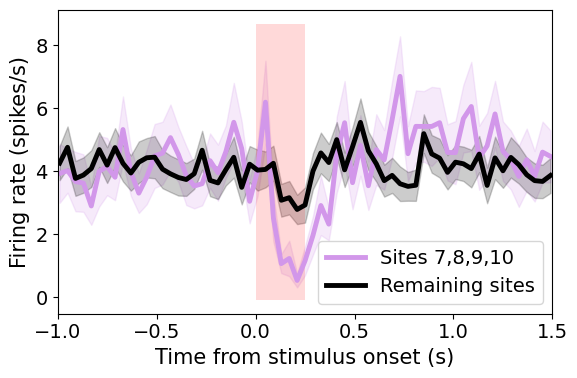

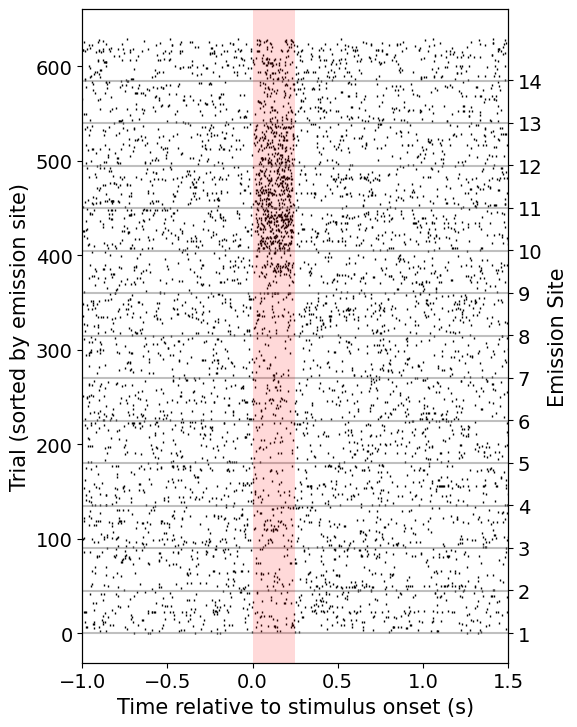

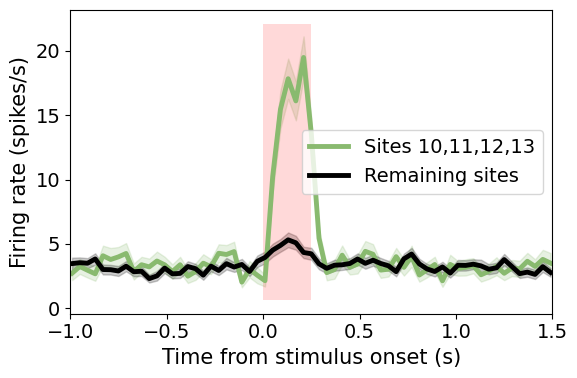

In [42]:
def plot_unit_raster_psth(session, unit_id, response_type='activated', sites_to_include=None,
                         window=None, bin_size=0.04, tau=0.02, buffer=0.15,
                         psth_linewidth=3.5, raster_markersize=2, 
                         figsize_raster=(6, 7.5), figsize_psth=(6, 4),
                         save_mode=False, save_dir='plots', save_prefix=''):
    """
    Plot raster and PSTH for a specific unit in a session.
    
    Parameters:
    -----------
    session : dict
        Session dict from all_sessions (must have spike_times, spike_clusters, stim_times, emission_sites)
    unit_id : int
        Cluster ID to plot
    response_type : str
        'activated' or 'inactivated' (affects colors and default window)
    sites_to_include : list, optional
        List of site groups to plot. Each element can be:
        - A single site (int): e.g., 15
        - A list of sites: e.g., [10,11,12,13]
        - The string 'remaining': plots all sites not explicitly listed
        If None, will plot all sites individually
    window : list, optional
        [start, end] time window in seconds. If None, uses [-1, 1.5]
    bin_size : float
        PSTH bin size in seconds
    tau : float
        Smoothing time constant in seconds
    buffer : float
        Additional time to analyze beyond window edges for smoothing
    psth_linewidth : float
        Line width for PSTH traces
    raster_markersize : float
        Marker size for raster ticks
    figsize_raster : tuple
        (width, height) for raster plot
    figsize_psth : tuple
        (width, height) for PSTH plot
    save_mode : bool
        If True, saves figures as SVG
    save_dir : str
        Directory to save figures
    save_prefix : str
        Prefix for saved filenames (useful for session identification)
    
    Returns:
    --------
    fig_raster, fig_psth : matplotlib figures
    """
    # Set defaults
    if window is None:
        window = [-1, 1.5]
    
    # Extract session data
    spike_times = session['spike_times']
    spike_clusters = session['spike_clusters']
    stim_times = session['stim_times']
    emission_sites = session['emission_sites']
    
    # Get spikes for this unit
    cluster_spikes = spike_times[spike_clusters == unit_id]
    
    # Sort trials by emission site
    sort_idx = np.argsort(emission_sites)
    sorted_stim_times = stim_times[sort_idx]
    sorted_emission_sites = emission_sites[sort_idx]
    unique_sites = np.unique(sorted_emission_sites)
    
    # Colors
    color = GREEN_COLOR if response_type == 'activated' else VIOLET_COLOR
    
    # ═══════════════════════════════════════════════════════════════
    # RASTER PLOT
    # ═══════════════════════════════════════════════════════════════
    
    fig_raster, ax_raster = plt.subplots(figsize=figsize_raster)
    
    for i, (stim_time, site) in enumerate(zip(sorted_stim_times, sorted_emission_sites)):
        window_spikes = cluster_spikes[
            (cluster_spikes >= stim_time + window[0]) & 
            (cluster_spikes <= stim_time + window[1])
        ]
        aligned_spikes = window_spikes - stim_time
        ax_raster.plot(aligned_spikes, np.full_like(aligned_spikes, i), 
                      '|', color='k', markersize=raster_markersize)
    
    ax_raster.set_xlabel('Time relative to stimulus onset (s)')
    ax_raster.set_ylabel('Trial (sorted by emission site)')
    ax_raster.set_xlim(window)
    
    # Add site boundaries
    site_boundaries = np.searchsorted(sorted_emission_sites, unique_sites)
    for boundary in site_boundaries:
        ax_raster.axhline(y=boundary - 0.5, color='gray', linestyle='-', alpha=0.5)
    
    # Add site labels on right y-axis
    ax2 = ax_raster.twinx()
    ax2.set_ylim(ax_raster.get_ylim())
    ax2.set_yticks(site_boundaries)
    ax2.set_yticklabels(unique_sites)
    ax2.set_ylabel('Emission Site')
    
    # Shade stimulation period
    ymin, ymax = ax2.get_ylim()
    ax2.fill_betweenx([ymin, ymax], 0, 0.25, facecolor='red', alpha=0.15)
    
    plt.tight_layout()
    
    if save_mode:
        os.makedirs(save_dir, exist_ok=True)
        filename = f'{save_prefix}unit{unit_id}_{response_type}_raster.svg'
        fig_raster.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
        print(f'Saved: {filename}')
    
    # ═══════════════════════════════════════════════════════════════
    # PSTH PLOT
    # ═══════════════════════════════════════════════════════════════
    
    # Set up binning with buffer
    analysis_window = [window[0] - buffer, window[1] + buffer]
    bins = np.arange(analysis_window[0], analysis_window[1] + bin_size, bin_size)
    bin_edges = bins[1:]
    
    # Causal filter for smoothing
    from scipy.signal import lfilter
    alpha = np.exp(-bin_size/tau)
    b, a = [1 - alpha], [1, -alpha]
    
    line_styles = ['-', '--', ':', '-.']
    
    fig_psth, ax_psth = plt.subplots(figsize=figsize_psth)
    
    # Build plot_items from sites_to_include
    if sites_to_include is None:
        # Default: plot each site individually
        plot_items = [[site] for site in unique_sites]
    else:
        plot_items = []
        specified_sites = set()
        for item in sites_to_include:
            if isinstance(item, (list, tuple)):
                plot_items.append(list(item))
                specified_sites.update(item)
            elif item != "remaining" and item != 15:
                plot_items.append([item])
                specified_sites.add(item)
        
        if "remaining" in sites_to_include:
            remaining_sites = [site for site in unique_sites if site not in specified_sites]
            if remaining_sites:
                plot_items.append("remaining")
    
    # Plot each site group
    for idx, item in enumerate(plot_items):
        if item == [15]:  # Skip site 15 if explicitly in list
            continue
            
        if item == "remaining":
            site_mask = np.isin(emission_sites, remaining_sites)
            label = 'Remaining sites'
            line_style = '-'
            plot_color = 'black'
        else:
            site_mask = np.isin(emission_sites, item)
            label = f'Sites {",".join(map(str, item))}' if len(item) > 1 else f'Site {item[0]}'
            line_style = line_styles[idx % len(line_styles)]
            plot_color = color
        
        site_stim_times = stim_times[site_mask]
        if len(site_stim_times) == 0:
            continue
        
        # Compute PSTH for each trial
        all_trial_rates = []
        for stim_time in site_stim_times:
            mask = (cluster_spikes >= stim_time + analysis_window[0]) & \
                   (cluster_spikes <= stim_time + analysis_window[1])
            these_spikes = cluster_spikes[mask] - stim_time
            hist, _ = np.histogram(these_spikes, bins=bins)
            all_trial_rates.append(hist / bin_size)
        
        all_trial_rates = np.array(all_trial_rates)
        
        # Apply smoothing
        smoothed_trials = np.array([lfilter(b, a, rate) for rate in all_trial_rates])
        smooth_mean = np.mean(smoothed_trials, axis=0)
        smooth_sem = np.std(smoothed_trials, axis=0) / np.sqrt(len(site_stim_times))
        
        # Plot only the display window
        display_mask = (bin_edges >= window[0]) & (bin_edges <= window[1])
        ax_psth.plot(bin_edges[display_mask], smooth_mean[display_mask],
                    color=plot_color, linestyle=line_style, label=label, 
                    linewidth=psth_linewidth)
        ax_psth.fill_between(bin_edges[display_mask],
                            smooth_mean[display_mask] - smooth_sem[display_mask],
                            smooth_mean[display_mask] + smooth_sem[display_mask],
                            color=plot_color, alpha=0.2)
    
    ax_psth.set_xlim(window)
    ax_psth.set_xlabel('Time from stimulus onset (s)')
    ax_psth.set_ylabel('Firing rate (spikes/s)')
    
    # Shade stimulation period
    ymin, ymax = ax_psth.get_ylim()
    ax_psth.fill_betweenx([ymin, ymax], 0, 0.25, facecolor='red', alpha=0.15)
    ax_psth.legend()
    
    plt.tight_layout()
    
    if save_mode:
        filename = f'{save_prefix}unit{unit_id}_{response_type}_psth.svg'
        fig_psth.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
        print(f'Saved: {filename}')
    
    return fig_raster, fig_psth


# ═══════════════════════════════════════════════════════════════
# Example usage
# ═══════════════════════════════════════════════════════════════

# Find target session
target_session_id = "AL0034_2024-12-05_en1_p0"
session = None
for s in all_sessions:
    if s["meta"]["session_id"] == target_session_id:
        session = s
        break

if session is None:
    print(f"Error: Could not find session {target_session_id}")
else:
    # Example 1: Plot unit 199 (inactivated) with custom site grouping
    fig_r, fig_p = plot_unit_raster_psth(
        session=session,
        unit_id=177,
        response_type='inactivated',
        sites_to_include=[[7,8,9,10], 15, 'remaining'],
        window=[-1, 1.5],
        save_mode=SAVE_MODE,
        save_dir=SAVE_DIR,
        save_prefix=f'{target_session_id}_'
    )
    plt.show()
    
    # Example 2: Plot unit 251 (activated) with different grouping
    fig_r, fig_p = plot_unit_raster_psth(
        session=session,
        unit_id=232,
        response_type='activated',
        sites_to_include=[[10,11,12,13], 'remaining'],
        window=[-1, 1.5],
        save_mode=SAVE_MODE,
        save_dir=SAVE_DIR,
        save_prefix=f'{target_session_id}_'
    )
    plt.show()
    
  

##  process all sessions + build combined DataFrames with responsive neurons

In [43]:
# ═══════════════════════════════════════════════════════════════════
# Cell 3: Core analysis functions
# ═══════════════════════════════════════════════════════════════════

N_EMISSION_SITES = 14
EMISSION_SITE_DEPTHS = np.array([70 + i * 100 for i in range(N_EMISSION_SITES)])  # µm



def add_probe_info(df, session):
    """Add unit depth, nearest sites, and waveform info to response DataFrame."""
    template_depths = session["template_depths"]  # Raw probe coordinates
    depths_from_surface = session["depths_from_surface"]  # Already computed from surface
    channel_positions = session["channel_positions"]
    top_of_shank = session["meta"]["top_of_shank_um"]
    trough_to_peak = session["trough_to_peak"]
    waveform_type = session["waveform_type"]
    qc_pass = session["qc_pass"]
    
    def _probe_info(cluster_id):
        depth_raw = template_depths[cluster_id]  # For nearest site calculation
        depth_from_surf = depths_from_surface[cluster_id]  # Use pre-computed!
        
        site_dists = np.abs(EMISSION_SITE_DEPTHS - depth_raw)
        nearest = np.argsort(site_dists)[:4]
        
        return pd.Series({
            "unit_depth": depth_raw,
            "depth_from_surface": depth_from_surf,  # Use the saved value
            "nearest_site_1": nearest[0],
            "nearest_site_2": nearest[1],
            "nearest_site_3": nearest[2],
            "nearest_site_4": nearest[3],
            "trough_to_peak_ms": trough_to_peak[cluster_id],
            "waveform_type": waveform_type[cluster_id] if cluster_id < len(waveform_type) else "",
            "qc_pass": qc_pass[cluster_id] if cluster_id < len(qc_pass) else True,
        })
    
    info = df["cluster_id"].apply(_probe_info)
    return pd.concat([df, info], axis=1)
    

def build_max_efficacy_df(df, proximal=True):
    """
    From full (cluster × site) response DataFrame, get one row per cluster
    at the most proximal emission site.
    """
    df = df.copy()
    df["abs_percent_change"] = df["percent_change"].abs()
    df["modulation_index"] = df.apply(
        lambda r: (r["mean_stim_rate"] - r["mean_pre_rate"]) /
                  (r["mean_stim_rate"] + r["mean_pre_rate"]),
        axis=1
    )
    df["proximal"] = df["emission_site"] == df["nearest_site_1"]
    
    if proximal:
        proximal_df = df[df["proximal"]]
        if len(proximal_df) == 0:
            return pd.DataFrame()
        idx = proximal_df.groupby("cluster_id")["abs_percent_change"].idxmax()
        out = df.loc[idx]
    else:
        idx = df.groupby("cluster_id")["abs_percent_change"].idxmax()
        out = df.loc[idx]
    
    return out.sort_values("cluster_id").reset_index(drop=True)



In [45]:
# ═══════════════════════════════════════════════════════════════════
# Cell 3: Core analysis functions
# ═══════════════════════════════════════════════════════════════════

N_EMISSION_SITES = 14
EMISSION_SITE_DEPTHS = np.array([70 + i * 100 for i in range(N_EMISSION_SITES)])  # µm


def find_responsive_neurons(session, stim_mask=None,
                            pre_window=(-0.5, 0), decrease_threshold=0.5,
                            increase_threshold=2, inh_min_firing_rate=2):
    """
    Find neurons that significantly change firing rate during optogenetic stimulation.
    
    Classification does NOT use p_value (applied as post-filter on sorted_df).
    Matches old notebook's active definition (line 1710).
    
    Parameters
    ----------
    session : dict from load_session()
    stim_mask : bool array, optional. If provided, only use these trials.
    increase_threshold : float, default 2
        Percent change threshold for activation (200% increase)
    decrease_threshold : float, default 0.5
        Percent change threshold for inactivation (50% decrease)
    inh_min_firing_rate : float, default 2
        Minimum pre-stim firing rate to classify as inactivated
    
    Returns DataFrame with one row per (cluster, emission_site) pair.
    """
    spike_times = session["spike_times"]
    spike_clusters = session["spike_clusters"]
    cluster_ids = np.unique(spike_clusters)
    
    stim_times = session["stim_times"]
    stim_durs  = session["stim_durations"]
    e_sites    = session["emission_sites"]
    power_mW   = session["power_mW"]
    
    if stim_mask is not None:
        stim_times = stim_times[stim_mask]
        stim_durs  = stim_durs[stim_mask]
        e_sites    = e_sites[stim_mask]
        power_mW   = power_mW[stim_mask]
    
    unique_sites = np.unique(e_sites)
    results = []
    
    for cluster_id in tqdm(cluster_ids, desc="Finding responsive neurons"):
        cluster_spikes = spike_times[spike_clusters == cluster_id]
        
        for site in unique_sites:
            site_mask = e_sites == site
            site_stim_times = stim_times[site_mask]
            site_stim_durs  = stim_durs[site_mask]
            site_power_mW   = power_mW[site_mask]
            
            pre_rates = []
            stim_rates = []
            
            for st, sd, pw in zip(site_stim_times, site_stim_durs, site_power_mW):
                pre_spikes = cluster_spikes[
                    (cluster_spikes >= st + pre_window[0]) &
                    (cluster_spikes < st + pre_window[1])
                ]
                stim_spikes = cluster_spikes[
                    (cluster_spikes >= st) & (cluster_spikes < st + sd)
                ]
                pre_rates.append(len(pre_spikes) / (pre_window[1] - pre_window[0]))
                stim_rates.append(len(stim_spikes) / sd)
            
            mean_pre  = np.mean(pre_rates)
            mean_stim = np.mean(stim_rates)
            if mean_pre == 0 or mean_stim == 0:
                continue
            
            percent_change = (mean_stim - mean_pre) / (mean_pre + 1e-8)
            t_stat, p_value = stats.ttest_rel(pre_rates, stim_rates)
            
            # Classification: NO p_value gate (post-filtered on sorted_df)
            if percent_change < -decrease_threshold and mean_pre > inh_min_firing_rate:
                response_type = "inactivated"
            elif percent_change > increase_threshold:
                response_type = "activated"
            else:
                response_type = "none"
            
            results.append({
                "cluster_id": cluster_id,
                "emission_site": site,
                "response_type": response_type,
                "mean_pre_rate": mean_pre,
                "mean_stim_rate": mean_stim,
                "percent_change": percent_change,
                "p_value": p_value,
                "power_mW": site_power_mW.tolist(),
                "stim_rates": stim_rates,
                "pre_rates": pre_rates,
            })
    
    return pd.DataFrame(results)

def add_probe_info(df, session):
    """Add unit depth, nearest sites, and waveform info to response DataFrame."""
    template_depths = session["template_depths"]
    channel_positions = session["channel_positions"]
    top_of_shank = session["meta"]["top_of_shank_um"]
    trough_to_peak = session["trough_to_peak"]
    waveform_type = session["waveform_type"]
    qc_pass = session["qc_pass"]
    
    def _probe_info(cluster_id):
        depth = template_depths[cluster_id]
        site_dists = np.abs(EMISSION_SITE_DEPTHS - depth)
        nearest = np.argsort(site_dists)[:4]
        depth_from_surface = np.abs(top_of_shank - depth)
        return pd.Series({
            "unit_depth": depth,
            "depth_from_surface": depth_from_surface,
            "nearest_site_1": nearest[0],
            "nearest_site_2": nearest[1],
            "nearest_site_3": nearest[2],
            "nearest_site_4": nearest[3],
            "trough_to_peak_ms": trough_to_peak[cluster_id],
            "waveform_type": waveform_type[cluster_id] if cluster_id < len(waveform_type) else "",
            "qc_pass": qc_pass[cluster_id] if cluster_id < len(qc_pass) else True,
        })
    
    info = df["cluster_id"].apply(_probe_info)
    return pd.concat([df, info], axis=1)


def build_max_efficacy_df(df, proximal=True):
    """
    From full (cluster × site) response DataFrame, get one row per cluster
    at the most proximal emission site.
    """
    df = df.copy()
    df["abs_percent_change"] = df["percent_change"].abs()
    df["modulation_index"] = df.apply(
        lambda r: (r["mean_stim_rate"] - r["mean_pre_rate"]) /
                  (r["mean_stim_rate"] + r["mean_pre_rate"]),
        axis=1
    )
    df["proximal"] = df["emission_site"] == df["nearest_site_1"]
    
    if proximal:
        proximal_df = df[df["proximal"]]
        if len(proximal_df) == 0:
            return pd.DataFrame()
        idx = proximal_df.groupby("cluster_id")["abs_percent_change"].idxmax()
        out = df.loc[idx]
    else:
        idx = df.groupby("cluster_id")["abs_percent_change"].idxmax()
        out = df.loc[idx]
    
    return out.sort_values("cluster_id").reset_index(drop=True)


# ═══════════════════════════════════════════════════════════════════
# Cell 4: Process all sessions → combined DataFrames
# ═══════════════════════════════════════════════════════════════════

all_sorted_dfs = []
all_max_eff_dfs = []
all_neuron_dfs = []

for i, session in enumerate(all_sessions):
    sid  = session["meta"]["session_id"]
    subj = session["meta"]["subject"]
    date = session["meta"]["date"]
    en   = session["meta"]["en"]
    print(f"\n[{i}] Processing {sid}...")
    print(f"    Trials: {session['meta']['n_trials']} ")    
    # Find responsive neurons (no additional masking needed)
    nrn_df = find_responsive_neurons(session, stim_mask=None)
    # Add probe info
    nrn_df = add_probe_info(nrn_df, session)
    
    # Apply QC filter
    n_before = len(nrn_df)
    nrn_df = nrn_df[nrn_df["qc_pass"]].copy()
    
    # Waveform inner merge: drop clusters without waveform data
    # TODO: ADD WVF DF FOR 7/21 SESSION
    # TODO: ADD QC for 10th session
    if date != '2025-07-21':
        nrn_df = nrn_df[nrn_df["trough_to_peak_ms"].notna()].copy()
    
    # Exclude noisy / switching artifact clusters 
    exclude_clusters = [4, 44, 53]
    nrn_df = nrn_df[~nrn_df["cluster_id"].isin(exclude_clusters)].copy()
    print(f"    After QC + wvf + exclude: {len(nrn_df)} / {n_before} rows kept")
    
    # Session metadata
    nrn_df["session"] = sid
    nrn_df["subject"] = subj
    nrn_df["date"] = date
    nrn_df["en"] = en
    
    # sorted_df: response != none, then p < 0.005 post-filter
    response_df = nrn_df[nrn_df["response_type"] != "none"].copy()
    sorted_df = response_df.copy()
    sorted_df["abs_percent_change"] = sorted_df["percent_change"].abs()
    sorted_df = sorted_df[sorted_df["p_value"] < 0.005].copy()
    sorted_df["top_chan"] = session["meta"]["top_chan"]
    
    # max_efficacy_df: one row per cluster at proximal site (all response types)
    max_eff_df = build_max_efficacy_df(nrn_df, proximal=True)
    max_eff_df["session"] = sid
    max_eff_df["subject"] = subj
    max_eff_df["date"] = date
    max_eff_df["en"] = en
    max_eff_df = max_eff_df[max_eff_df["p_value"] < 0.005].copy()
    
    n_act = (sorted_df["response_type"] == "activated").sum()
    n_inh = (sorted_df["response_type"] == "inactivated").sum()
    print(f"    Significant: {n_act} act, {n_inh} inh | max_eff: {len(max_eff_df)}")
    
    all_sorted_dfs.append(sorted_df)
    all_max_eff_dfs.append(max_eff_df)
    all_neuron_dfs.append(nrn_df)

# Combine across sessions
sorted_df = pd.concat(all_sorted_dfs, ignore_index=True)
max_efficacy_df = pd.concat(all_max_eff_dfs, ignore_index=True)
all_neuron_df = pd.concat(all_neuron_dfs, ignore_index=True)

# Add sess_key for easy cross-referencing
for df in [sorted_df, max_efficacy_df, all_neuron_df]:
    df['sess_key'] = df.apply(lambda r: f"{r['subject']}_{r['date']}_en{int(r['en'])}", axis=1)

print(f"\n{'='*60}")
print(f"Combined sorted_df:      {len(sorted_df)} rows, "
      f"{sorted_df['cluster_id'].nunique()} unique neurons")
print(f"Combined max_efficacy_df: {len(max_efficacy_df)} rows")
print(f"Combined all_neuron_df:   {len(all_neuron_df)} rows")
print(f"{'='*60}")


[0] Processing AL0033_2025-07-21_en3_p1...
    Trials: 210 (filter already applied during ingestion)


Finding responsive neurons: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:01<00:00, 106.52it/s]


    After QC + wvf + exclude: 397 / 942 rows kept
    Significant: 4 act, 1 inh | max_eff: 2

[1] Processing AL0033_2025-07-22_en1_p0...
    Trials: 210 (filter already applied during ingestion)


Finding responsive neurons: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:02<00:00, 87.83it/s]


    After QC + wvf + exclude: 430 / 1873 rows kept
    Significant: 5 act, 4 inh | max_eff: 2

[2] Processing AL0033_2025-07-22_en3_p0...
    Trials: 210 (filter already applied during ingestion)


Finding responsive neurons: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [00:03<00:00, 77.75it/s]


    After QC + wvf + exclude: 677 / 2373 rows kept
    Significant: 20 act, 91 inh | max_eff: 16

[3] Processing AL0034_2024-12-05_en1_p0...
    Trials: 630 (filter already applied during ingestion)


Finding responsive neurons: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:09<00:00, 36.04it/s]


    After QC + wvf + exclude: 1288 / 3694 rows kept
    Significant: 12 act, 82 inh | max_eff: 27

[4] Processing AL0034_2024-12-06_en1_p1...
    Trials: 700 (filter already applied during ingestion)


Finding responsive neurons: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 306/306 [00:07<00:00, 42.89it/s]


    After QC + wvf + exclude: 406 / 3756 rows kept
    Significant: 34 act, 34 inh | max_eff: 15

[5] Processing AL0039_2025-07-23_en1_p0...
    Trials: 392 (filter already applied during ingestion)


Finding responsive neurons: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [00:06<00:00, 55.60it/s]


    After QC + wvf + exclude: 1020 / 3419 rows kept
    Significant: 2 act, 25 inh | max_eff: 9

[6] Processing AL0039_2025-07-23_en3_p2...
    Trials: 392 (filter already applied during ingestion)


Finding responsive neurons: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 349/349 [00:06<00:00, 51.74it/s]


    After QC + wvf + exclude: 1345 / 3675 rows kept
    Significant: 24 act, 55 inh | max_eff: 37

[7] Processing AL0039_2025-07-24_en3_p1...
    Trials: 420 (filter already applied during ingestion)


Finding responsive neurons: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 443/443 [00:08<00:00, 52.31it/s]


    After QC + wvf + exclude: 2347 / 5108 rows kept
    Significant: 6 act, 15 inh | max_eff: 11

[8] Processing AL0039_2025-07-24_en5_p2...
    Trials: 392 (filter already applied during ingestion)


Finding responsive neurons: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 430/430 [00:08<00:00, 51.85it/s]


    After QC + wvf + exclude: 2080 / 5014 rows kept
    Significant: 31 act, 53 inh | max_eff: 30

Combined sorted_df:      498 rows, 186 unique neurons
Combined max_efficacy_df: 149 rows
Combined all_neuron_df:   9990 rows


In [36]:
max_efficacy_df['p_value'].max()

0.00479062598784642

## PANEL E

AL_0033 0
AL_0033 1
AL_0033 2
AL_0034 3
AL_0034 4
AL_0039 5
AL_0039 6
AL_0039 7
AL_0039 8
Session → Subject mapping:
  0: AL0033_2025-07-21_en3_p1                  subject=AL_0033  sorted=0  max_eff=0
  1: AL0033_2025-07-22_en1_p0                  subject=AL_0033  sorted=0  max_eff=0
  2: AL0033_2025-07-22_en3_p0                  subject=AL_0033  sorted=0  max_eff=0
  3: AL0034_2024-12-05_en1_p0                  subject=AL_0034  sorted=0  max_eff=0
  4: AL0034_2024-12-06_en1_p1                  subject=AL_0034  sorted=0  max_eff=0
  5: AL0039_2025-07-23_en1_p0                  subject=AL_0039  sorted=0  max_eff=0
  6: AL0039_2025-07-23_en3_p2                  subject=AL_0039  sorted=0  max_eff=0
  7: AL0039_2025-07-24_en3_p1                  subject=AL_0039  sorted=0  max_eff=0
  8: AL0039_2025-07-24_en5_p2                  subject=AL_0039  sorted=0  max_eff=0
  AL_0033: dropping 2 rows with NaN trough_to_peak
  All : dropping 2 rows with NaN trough_to_peak


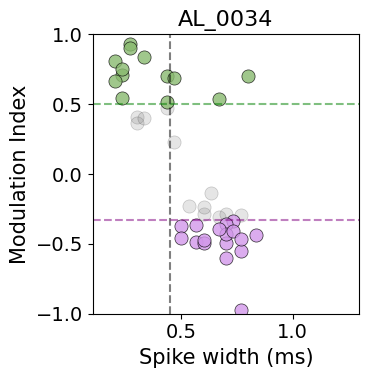

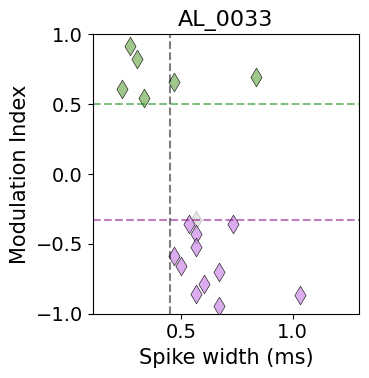

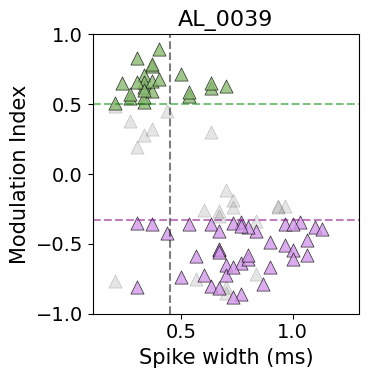

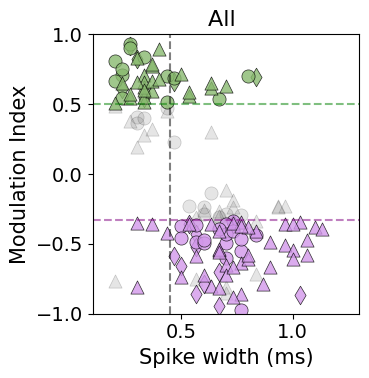

In [37]:
# ═══════════════════════════════════════════════════════════════════
# Cell 6: Modulation index vs spike width (Panel E top)
# ═══════════════════════════════════════════════════════════════════

# ── Add subject column to both DataFrames ────────────────────────
for i, session in enumerate(all_sessions):
    subj = session["meta"]["subject"]
    sorted_df.loc[sorted_df["session"] == i, "subject"] = subj
    print(subj, i)
    max_efficacy_df.loc[max_efficacy_df["session"] == i, "subject"] = subj
    all_neuron_df.loc[all_neuron_df["session"] == i, "subject"] = subj

# Verify mapping
print("Session → Subject mapping:")
for i, session in enumerate(all_sessions):
    n_sorted = (sorted_df["session"] == i).sum()
    n_max = (max_efficacy_df["session"] == i).sum()
    print(f"  {i}: {session['meta']['session_id']:40s}  subject={session['meta']['subject']}  "
          f"sorted={n_sorted}  max_eff={n_max}")


def plot_mod_vs_width(df, figsize=(4, 4), title=""):
    """Scatter plot of modulation index vs trough-to-peak spike width."""
    df = df.copy()
    fig, ax = plt.subplots(figsize=figsize)
    
    # Ensure modulation_index exists
    if "modulation_index" not in df.columns:
        df["modulation_index"] = (df["mean_stim_rate"] - df["mean_pre_rate"]) / \
                                  (df["mean_stim_rate"] + df["mean_pre_rate"])
    
    # Drop rows with NaN trough_to_peak
    valid = df["trough_to_peak_ms"].notna()
    if valid.sum() < len(df):
        print(f"  {title}: dropping {(~valid).sum()} rows with NaN trough_to_peak")
    df = df[valid]
    
    activated_mask   = (df["response_type"] == "activated") & (df["p_value"] < 0.005)
    inactivated_mask = (df["response_type"] == "inactivated") & (df["p_value"] < 0.005)
    none_mask        = ~(activated_mask | inactivated_mask)
    
    colors = {
        "activated": GREEN_COLOR,
        "inactivated": VIOLET_COLOR,
        "none": "grey",
    }
    
    # Markers by subject: AL_0034='o', AL_0033='d', AL_0039='^'
    subject_markers = {
        "AL_0034": 'o',
        "AL_0036": 'o',
        "AL_0033": 'd',
        "AL_0039": '^',
    }
    
    for condition, cond_mask in [("none", none_mask), ("activated", activated_mask), ("inactivated", inactivated_mask)]:
        alpha = 0.2 if condition == "none" else 0.8
        for subject in df["subject"].unique():
            m = cond_mask & (df["subject"] == subject)
            if m.sum() == 0:
                continue
            marker = subject_markers.get(subject, 'o')
            ax.scatter(
                df.loc[m, "trough_to_peak_ms"],
                df.loc[m, "modulation_index"],
                color=colors[condition],
                marker=marker,
                alpha=alpha,
                edgecolor="black",
                linewidth=0.5,
                s=90,
            )
    
    ax.axvline(0.45, linestyle="--", alpha=0.5, color="black")
    ax.axhline(-0.33, linestyle="--", alpha=0.5, color="purple")
    ax.axhline(0.5, linestyle="--", alpha=0.5, color="green")
    
    ax.set_xlabel("Spike width (ms)")
    ax.set_ylabel("Modulation Index")
    ax.set_xlim(0.1, 1.3)
    ax.set_ylim(-1, 1)
    
    if title:
        ax.set_title(title)
    
    plt.tight_layout()
    return fig


# ── Per-animal plots (grouped by subject) ────────────────────────
fig_34  = plot_mod_vs_width(max_efficacy_df[max_efficacy_df["subject"] == "AL_0034"], title="AL_0034")
fig_33  = plot_mod_vs_width(max_efficacy_df[max_efficacy_df["subject"] == "AL_0033"], title="AL_0033")
fig_39  = plot_mod_vs_width(max_efficacy_df[max_efficacy_df["subject"] == "AL_0039"], title="AL_0039")
fig_all = plot_mod_vs_width(max_efficacy_df[max_efficacy_df["subject"] != "AL_0036"], title="All ")

if SAVE_MODE:
    fig_34.savefig(os.path.join(SAVE_DIR, "ttp_scatter_AL0034.svg"), bbox_inches="tight")
    fig_33.savefig(os.path.join(SAVE_DIR, "ttp_scatter_AL0033.svg"), bbox_inches="tight")
    fig_39.savefig(os.path.join(SAVE_DIR, "ttp_scatter_AL0039.svg"), bbox_inches="tight")
    fig_all.savefig(os.path.join(SAVE_DIR, "ttp_scatter_all.svg"), bbox_inches="tight")

plt.show()

## Panel F


Added top_of_shank to 498/498 rows
Unique top_of_shank values: [1400.0, 1520.0, 1540.0, 1580.0, 1640.0, 1700.0, 1720.0]
  Plotted 155 points, skipped: {'no_top': 0, 'site_15': 6, 'low_rate': 1, 'p_value': 0}
  Pearson r=0.735, p=0.0000, n=155
  Plotted 118 points, skipped: {'no_top': 0, 'site_15': 7, 'low_rate': 0, 'p_value': 0}
  Pearson r=0.591, p=0.0000, n=118
  Plotted 206 points, skipped: {'no_top': 0, 'site_15': 5, 'low_rate': 0, 'p_value': 0}
  Pearson r=0.768, p=0.0000, n=206
  Plotted 479 points, skipped: {'no_top': 0, 'site_15': 18, 'low_rate': 1, 'p_value': 0}
  Pearson r=0.738, p=0.0000, n=479


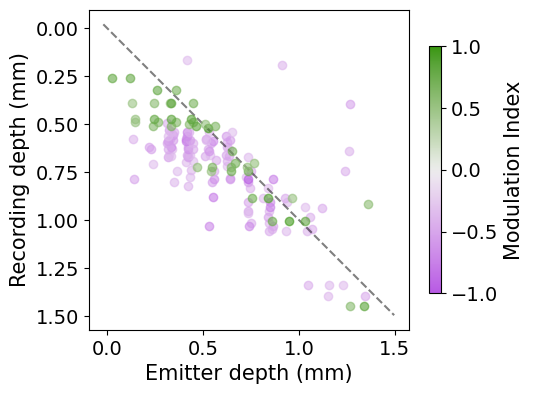

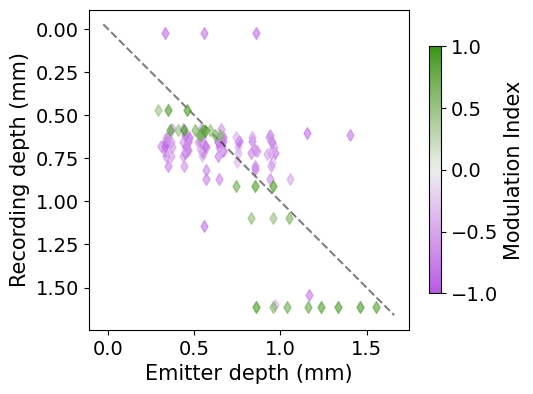

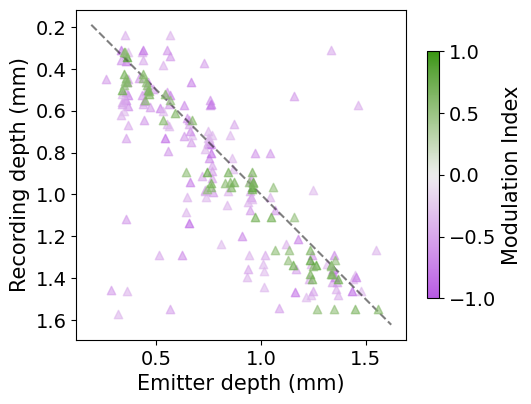

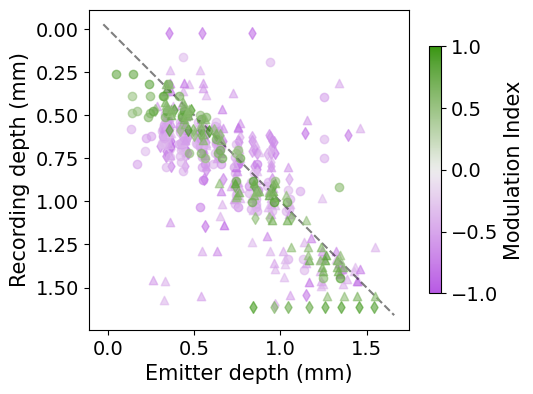

In [38]:
# ═══════════════════════════════════════════════════════════════════
# Cell 7: Depth comparison plot (Panel E bottom)
# ═══════════════════════════════════════════════════════════════════

from matplotlib.colors import ListedColormap

# Add top_of_shank via session_id (string, not int)
session_top_lookup = {s["meta"]["session_id"]: s["meta"]["top_of_shank_um"] for s in all_sessions}
sorted_df["top_of_shank"] = sorted_df["session"].map(session_top_lookup)

print(f"Added top_of_shank to {sorted_df['top_of_shank'].notna().sum()}/{len(sorted_df)} rows")
print(f"Unique top_of_shank values: {sorted(sorted_df['top_of_shank'].dropna().unique())}")


def plot_depth_comparison_modulation(df, figsize=(5.5, 5.5), axes_units="mm", p_val_thresh=0.005):
    """Plot recording depth vs emitter depth, colored by modulation index."""
    df = df.copy()
    
    if "modulation_index" not in df.columns:
        df["modulation_index"] = (df["mean_stim_rate"] - df["mean_pre_rate"]) / \
                                  (df["mean_stim_rate"] + df["mean_pre_rate"])
    
    fig, ax = plt.subplots(figsize=figsize)
    
    cmap = ListedColormap(cc.gwv[::-1])
    norm = plt.Normalize(vmin=-1, vmax=1)
    jitter_amount = 20  # µm
    
    # Markers by subject (same as Cell 6)
    subject_markers = {"AL_0034": 'o', "AL_0033": 'd', "AL_0039": '^'}
    
    site_depths_all = []
    unit_depths_all = []
    n_skipped = {"no_top": 0, "site_15": 0, "low_rate": 0, "p_value": 0}
    
    for _, row in df.iterrows():
        emission_site = int(row["emission_site"])
        
        if emission_site >= 15:
            n_skipped["site_15"] += 1
            continue
        
        if row.get("p_value", 0) > p_val_thresh:
            n_skipped["p_value"] += 1
            continue
            
        if row.get("mean_pre_rate", 0) < 1 and row.get("mean_stim_rate", 0) < 2:
            n_skipped["low_rate"] += 1
            continue
        
        top_of_shank = row.get("top_of_shank", None)
        if top_of_shank is None or np.isnan(top_of_shank):
            n_skipped["no_top"] += 1
            continue
        
        channel_depth = row.get("depth_from_surface", None)
        if channel_depth is None or np.isnan(channel_depth):
            unit_depth = row.get("unit_depth", None)
            if unit_depth is None or np.isnan(unit_depth):
                n_skipped["no_top"] += 1
                continue
            channel_depth = np.abs(top_of_shank - unit_depth)
        
        if emission_site < len(EMISSION_SITE_DEPTHS):
            site_depth_raw = EMISSION_SITE_DEPTHS[emission_site]
        else:
            n_skipped["site_15"] += 1
            continue
            
        site_depth = np.abs(top_of_shank - site_depth_raw)
        
        if axes_units == "mm":
            channel_depth = channel_depth / 1000
            site_depth = site_depth / 1000
            jitter = np.random.uniform(-jitter_amount, jitter_amount) / 1000
        else:
            jitter = np.random.uniform(-jitter_amount, jitter_amount)
        
        color = cmap(norm(row["modulation_index"]))
        z_order = 300 if row["modulation_index"] > 0.3 else 0
        marker = subject_markers.get(row.get("subject", ""), 'o')
        
        ax.scatter(site_depth + jitter, channel_depth, color=color, marker=marker,
                   alpha=0.6, zorder=z_order)
        site_depths_all.append(site_depth)
        unit_depths_all.append(channel_depth)
    
    print(f"  Plotted {len(site_depths_all)} points, skipped: {n_skipped}")
    
    if len(site_depths_all) > 2:
        r, p = stats.pearsonr(site_depths_all, unit_depths_all)
        print(f"  Pearson r={r:.3f}, p={p:.4f}, n={len(site_depths_all)}")
    
    if len(site_depths_all) > 0:
        all_vals = site_depths_all + unit_depths_all
        lim_min = min(all_vals) - 0.05
        lim_max = max(all_vals) + 0.05
        ax.plot([lim_min, lim_max], [lim_min, lim_max], "k--", alpha=0.5)
    
    ax.set_xlabel(f"Emitter depth ({axes_units})")
    ax.set_ylabel(f"Recording depth ({axes_units})")
    ax.set_aspect("equal")
    ax.invert_yaxis()
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
    cbar.set_label("Modulation Index")
    
    plt.tight_layout()
    return fig


base_font_size = 14
plt.rcParams.update({
    'font.size': base_font_size,
    'axes.titlesize': base_font_size + 2,
    'axes.labelsize': base_font_size + 1,
    'xtick.labelsize': base_font_size,
    'ytick.labelsize': base_font_size,
    'legend.fontsize': base_font_size,
    'figure.titlesize': base_font_size + 4
})

fig1 = plot_depth_comparison_modulation(sorted_df[sorted_df['subject'] == 'AL_0034'], figsize=(5.5, 5.5))
fig2 = plot_depth_comparison_modulation(sorted_df[sorted_df['subject'] == 'AL_0033'], figsize=(5.5, 5.5))
fig3 = plot_depth_comparison_modulation(sorted_df[sorted_df['subject'] == 'AL_0039'], figsize=(5.5, 5.5))
fig4 = plot_depth_comparison_modulation(sorted_df, figsize=(5.5, 5.5))

if SAVE_MODE:
    fig1.savefig('plots/panel_e_AL0034.svg')
    fig2.savefig('plots/panel_e_AL0033.svg')
    fig3.savefig('plots/panel_e_AL0039.svg')
    fig4.savefig('plots/panel_e_ALL.svg')
    
plt.show()